# Leverage by Borrowing Cash

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we maximize the portfolio's expected return while constraining the admissible variance (risk) to a given maximum level. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

To this basic model, we add *leverage*. Leverage means borrowing capital from a third party to buy more assets (and paying interest on the borrowed capital). This magnifies both the potential upside and downside.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation
Mathematically, this results in a convex quadratically constrained optimization problem.

### Model Parameters

The following parameters are used within the model:

- $\bar\sigma^2$: maximal admissible variance for the portfolio return
- $c_\text{rf}$: interest on the risk-free asset. For simplicity, we assume the same interest rate for lending and borrowing.
- $\ell_\text{rf}$: maximal short on risk-free asset
- $u_\text{rf}$: maximal investment in risk-free asset

In [5]:
# Values for the model parameters:
V = 4.0  # Maximal admissible variance (sigma^2)
c_rf = 2 / 52  # interest rate on risk-free asset
l_rf = -0.3  # maximal borrowing of risk-free asset
u_rf = 1  # maximal investment in risk-free asset

### Decision Variables
We require two types of decision variables:

1. The proportions of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

2. The proportion $x_\text{rf}$ invested in the risk-free asset. This may be positive or negative. If positive, we gain a risk-free return; if negative, we pay interest on the borrowed amount.


### Variable Bounds

Each position must be nonnegative:

$$ x_i\geq 0 \;, \, i \in S$$

The risk-free position must be within its bounds:

$$ \ell_\text{rf} \leq x_\text{rf} \leq u_\text{rf} $$

Setting the upper bound $u_\text{rf}=1$ means the portfolio is allowed to be fully invested in the risk-free asset.

In [6]:
%%capture
# Create an empty optimization model
m = gp.Model()

# Add variables: x[i] denotes the proportion invested in stock i
x = m.addMVar(len(mu), name="x")

# Risk-free allocation
x_rf = m.addVar(lb=l_rf, ub=u_rf, name="x_rf")

###  Constraints

The budget constraint ensures that all capital (both initial and borrowed) is invested:

$$\sum_{i \in S} x_i + x_\text{rf} = 1$$

The estimated risk must not exceed a prespecified maximal admissible level of variance $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

In [7]:
%%capture
# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() + x_rf == 1, name="Budget_Constraint")

# Upper bound on variance
risk_constr = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Variance")

###  Objective Function

The objective is to maximize the expected return of the portfolio. We need to account for risk-free returns and costs for borrowing cash:
\begin{equation*}
\max_x \underbrace{c_\text{rf} x_\text{rf}}_{\substack{\text{cost for borrowing}\\\text{or risk-free return}}} + \underbrace{\mu^\top x}_\text{expected return from stocks}
\end{equation*}

In [8]:
m.setObjective(c_rf * x_rf + mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

We now solve the optimization problem:

In [9]:
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 1 rows, 463 columns and 463 nonzeros


Model fingerprint: 0xc5359fbf


Model has 1 quadratic constraint


Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


  QMatrix range    [3e-03, 1e+02]


  Objective range  [4e-02, 6e-01]


  Bounds range     [3e-01, 1e+00]


  RHS range        [1e+00, 1e+00]


  QRHS range       [4e+00, 4e+00]


Presolve time: 0.04s


Presolved: 464 rows, 926 columns, 107879 nonzeros


Presolved model has 1 second-order cone constraint


Ordering time: 0.01s


Barrier statistics:


 AA' NZ     : 1.074e+05


 Factor NZ  : 1.079e+05 (roughly 1 MB of memory)


 Factor Ops : 3.341e+07 (less than 1 second per iteration)


 Threads    : 1


                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.36004448e+01  1.52173653e-01  5.78e+01 6.79e-01  4.09e-02     0s


   1   1.85351518e+00  1.75506108e+00  6.76e+00 7.47e-07  6.08e-03     0s


   2   5.26444573e-01  9.73208598e-01  1.18e+00 1.48e-07  1.50e-03     0s


   3   2.58180913e-01  5.35781906e-01  1.30e-06 1.75e-08  2.99e-04     0s


   4   2.74073099e-01  4.36667485e-01  1.43e-12 1.15e-09  1.75e-04     0s


   5   3.46759821e-01  3.86258876e-01  2.22e-15 2.28e-10  4.26e-05     0s


   6   3.60280539e-01  3.63495642e-01  1.05e-15 2.37e-11  3.46e-06     0s


   7   3.61562696e-01  3.61702796e-01  6.49e-15 9.30e-13  1.51e-07     0s


   8   3.61658821e-01  3.61673013e-01  7.21e-13 2.39e-14  1.53e-08     0s


   9   3.61665753e-01  3.61665955e-01  6.12e-13 5.33e-15  2.18e-10     0s


Barrier solved model in 9 iterations and 0.25 seconds (0.57 work units)


Optimal objective 3.61665753e-01


Display basic solution data for all non-negligible positions; for clarity we've rounded all solution quantities to five digits.

In [10]:
print(f"Expected return: {m.ObjVal:.6f}")
print(f"Variance:        {x.X @ Sigma @ x.X:.6f}")
print(f"Solution time:   {m.Runtime:.2f} seconds\n")

print(f"Total investment:     {x.X[x.X>1e-5].sum():.6f}")
print(f"Risk-free allocation: {x_rf.X:.6f}")
print(f"Number of positions:  {np.count_nonzero(x.X[abs(x.X)>1e-5])}")

# Print all assets with a non-negligible position
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
    },
).round(6)
df[(abs(df["x"]) > 1e-5)].sort_values("x", ascending=False)

Expected return: 0.361666
Variance:        3.999999
Solution time:   0.25 seconds

Total investment:     1.180790
Risk-free allocation: -0.180793
Number of positions:  31


x
LLY   0.234378
PGR   0.130469
KDP   0.109984
TMUS  0.061071
NVDA  0.059577
KR    0.059146
DPZ   0.058659
TTWO  0.052455
WM    0.050070
NOC   0.049313
ODFL  0.039862
ORLY  0.035956
AVGO  0.034829
WST   0.029040
MSFT  0.027461
ED    0.018846
MKTX  0.018722
AZO   0.018125
MNST  0.015005
CLX   0.014768
META  0.013696
HRL   0.010052
NFLX  0.009693
WMT   0.008259
UNH   0.007706
DXCM  0.004475
XEL   0.004328
CBOE  0.003246
MOH   0.000780
WEC   0.000628
CME   0.000189

## Comparison with the unconstrained portfolio without leverage

We can also compute the portfolio without leverage and compare the resulting portfolios.

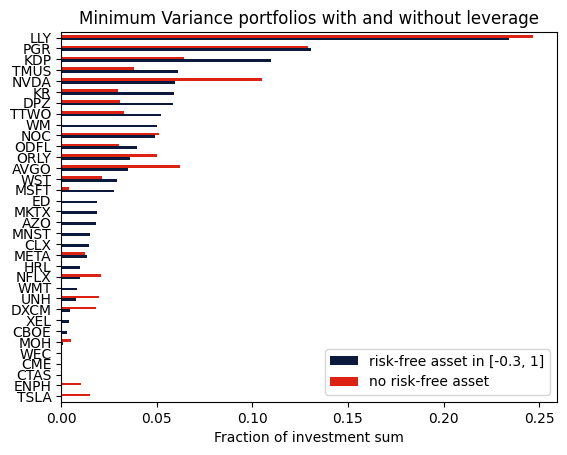

In [11]:
# adjust RHS of short constraint
x_rf.lb = 0
x_rf.ub = 0
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
mask = (abs(df["x"]) > 1e-5) | (x.X > 1e-5)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "risk-free asset in [-0.3, 1]": df["x"],
        "no risk-free asset": x.X[mask],
    },
).sort_values(by=["risk-free asset in [-0.3, 1]"], ascending=True)

axs = df2.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without leverage")
plt.show()

## Efficient Frontiers

The efficient frontier reveals the balance between risk and return in investment portfolios. It shows the best-expected return level that can be achieved for a specified risk level.
We compute this by solving the above optimization problem for a sample of admissible risk levels with and without the risk-free asset.
When we restrict investment amounts in the risk-free asset, that is $u_\text{rf} < 1$, the model may be infeasible for very small risk levels.

In [12]:
risks = np.linspace(0, 6, 30)
rf_bnds = [(0, 0), (0, 1), (-0.3, 0), (-1, -0.2)]


returns = pd.DataFrame(index=risks)

# prevent Gurobi log output
m.params.OutputFlag = 0

for lb, ub in rf_bnds:
    name = f"[{lb}, {ub}]"
    x_rf.LB = lb
    x_rf.UB = ub

    r = np.zeros(risks.shape)
    # solve the model for each risk level
    for i, risk_level in enumerate(risks):
        # set risk level: RHS of risk constraint
        risk_constr.QCRHS = risk_level**2

        m.optimize()
        # check status and store data
        if m.Status == gp.GRB.OPTIMAL:
            r[i] = m.ObjVal
        else:
            r[i] = float("NaN")

    returns[name] = r

We can display the efficient frontiers for all strategies. We plot the expected returns (on the $y$-axis) against the standard deviation $\sqrt{x^\top\Sigma x}$ of the expected returns (on the $x$-axis).

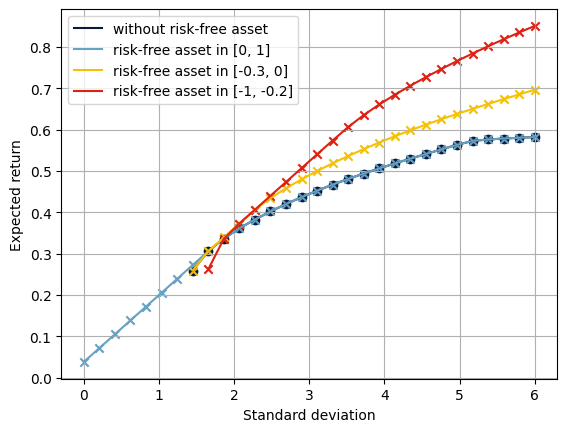

In [13]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
markers = ["o", "x", "x", "x"]
fig, axs = plt.subplots()

for column, color, marker in zip(returns.columns, colors, markers):
    axs.scatter(x=returns.index, y=returns[column], marker=marker, color=color)
    label = (
        "without risk-free asset"
        if column == "[0, 0]"
        else f"risk-free asset in {column}"
    )
    axs.plot(
        returns.index,
        returns[column],
        label=label,
        color=color,
    )
axs.set_xlabel("Standard deviation")
axs.set_ylabel("Expected return")
axs.legend()
axs.grid()

plt.show()

If we allow investing in a risk-free asset, the portfolio variance can be arbitrarily small. If one invests all capital into the risk-free asset, the variance (and standard deviation) is 0.
Without that possibility (i.e., $x_\text{rf}\leq 0$), the minimal possible risk is greater than 0.
If we can invest in the risk-free asset, the left-most part of the efficient frontier is a straight line from the portfolio that invests the entire capital into the risk-free asset to the minimal-variance portfolio.
If we allow higher risk, including the ability to borrow cash, this shifts the efficient frontier towards higher returns.

## Takeaways
* Leverage can be modeled by adding a variable for the risk-free portion that can take negative values.
* Different strategies can be tested by modifying bounds and right-hand sides; there is no need to rebuild the model.